### **Recipe 2: Calculating the meridional overturning stream function in latitude-tracer coordinates**

**Description:** Recipe showing how to calculate the Atlantic Meridional Overturning Stream Function in potential density-coordinates using annual mean outputs from the NOC Near-Present-Day eORCA1 global configuration of NEMO.

In [1]:
# -- Import required Python packages -- #
import gsw
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

# -- Import nemo_cookbook tools -- #
from nemo_cookbook import compute_moc_tracer

#### **Optional: Connect Client to Dask Local Cluster to run analysis in parallel.**

**Note:** Although using Dask is not strictly necessary for this simple example using eORCA1, if we wanted to generalise this recipe to eORCA025 or eORCA12 outputs, using Dask would be essential to avoid unnecessary slow calculations using only a single process.

In [ ]:
# -- Initialise Dask Local Cluster -- #
import dask
from dask.distributed import Client, LocalCluster

# Update temporarty directory for Dask workers:
dask.config.set({'temporary_directory': '/home/otooth/work/Diagnostics/proj_NPD_diag/nemo_cookbook/recipes',
                 'local_directory': '/home/otooth/work/Diagnostics/proj_NPD_diag/nemo_cookbook/recipes'
                 })

# Create Local Cluster:
cluster = LocalCluster(n_workers=4, threads_per_worker=5, memory_limit='5GB')
client = Client(cluster)
client

##### **Let's begin by importing our NEMO model grid variables:**

In [2]:
# -- Import eORCA1 domain data -- #
# Define directory path to ancillary files:
domain_filepath = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1/domain"

# Open eORCA1 model grid data:
ds_domain = xr.open_zarr(domain_filepath, consolidated=True, chunks={})

# Extract zonal grid cell widths (m):
e1v = ds_domain['e1v'].squeeze()
# Extract Atlantic Ocean mask:
atl_mask = ds_domain['atlmsk'].squeeze()

##### **Next, we need to import the conservative temperature and absolute salinity stored at T-points**

In [3]:
# -- Import eORCA1 tracer data -- #
# Define directory path to model output files:
output_dir = "https://noc-msm-o.s3-ext.jc.rl.ac.uk/npd-eorca1-jra55v1"

# Extract conservative temperature (C):
thetao_con = xr.open_zarr(f"{output_dir}/T1y/thetao_con", consolidated=True, chunks={})['thetao_con']
# Extract absolute salinity (g/kg):
so_abs = xr.open_zarr(f"{output_dir}/T1y/so_abs", consolidated=True, chunks={})['so_abs']

# Calculate potential density anomaly referenced to the sea surface (kg/m3):
sigma0 = gsw.density.sigma0(CT=thetao_con, SA=so_abs)
sigma0.name = 'sigma0'

##### **Next, we need to import the meridional velocity field and vertical grid cell thickness stored at V-points**

In [4]:
# -- Import eORCA1 velocity data -- #
# Extract vertical grid cell thicknesses (m):
e3v = xr.open_zarr(f"{output_dir}/V1y/e3v", consolidated=True, chunks={})['e3v']
# Extract meridional velocities (m/s):
vo = xr.open_zarr(f"{output_dir}/V1y/vo", consolidated=True, chunks={})['vo']

##### **Now all our input variables are ready, let's calculate the Atlantic Meridional Overturning Stream Function in density-coordinates**

In [5]:
# -- Create Task: Compute Atlantic Meridional Overturning Circulation (MOC_sigma0) in density-coordinates -- #
# Apply the Atlantic Ocean sector mask and accumulate from the lightest to the densest isopycnal surface:
moc_sigma0_atl = compute_moc_tracer(vo=vo,
                                    e1v=e1v,
                                    e3v=e3v,
                                    tracer=sigma0,
                                    tracer_bins=np.arange(21, 29, 0.01),
                                    dir = '+1',
                                    mask=atl_mask,
                                    )

# Notice that the output is a dask array, so we haven't actually computed the MOC_sigma0 yet.
moc_sigma0_atl

<xarray.DataArray 'moc_sigma0' (time_counter: 48, sigma0_bins: 799, y: 331)> Size: 102MB
dask.array<nancumsum, shape=(48, 799, 331), dtype=float64, chunksize=(48, 799, 331), chunktype=numpy.ndarray>
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 384B 1976-07-02 ... 2023-07-0...
  * sigma0_bins   (sigma0_bins) object 6kB (21.0, 21.01] ... (28.980000000001...
  * y             (y) int64 3kB 0 1 2 3 4 5 6 7 ... 324 325 326 327 328 329 330
Attributes:
    units:          Sv
    long_name:      meridional overturning stream function in sigma0 coordinates
    standard_name:  moc_sigma0

In [6]:
# -- Complete Task: Compute Meridional Overturning Circulation (MOC_sigma0) in density-coordinates -- #
moc_sigma0_atl = moc_sigma0_atl.compute()

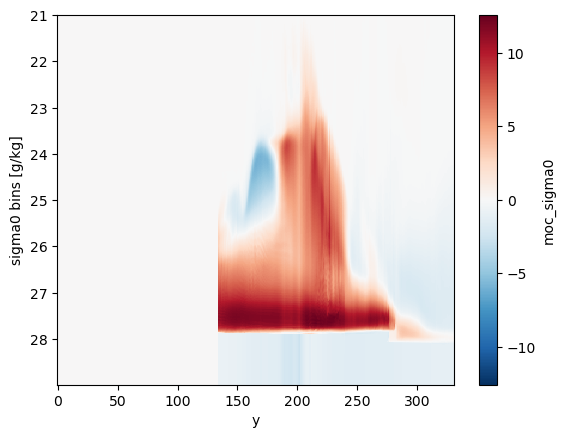

In [7]:
# -- Plot time-mean MOC_sigma0 -- #
moc_sigma0_atl.mean(dim='time_counter').plot(yincrease=False)